<a href="https://colab.research.google.com/github/sugarme/gotch/blob/master/example/yolo/gotch_yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GoTch (Pytorch C++ APIs Go Binding) - YOLO v3

This notebook using

1. [GoTch - Pytorch C++ APIs Go bindind](https://github.com/sugarme/gotch)
2. [GopherNotes - Jupyter Notebook Go kernel](https://github.com/gopherdata/gophernotes)

## Install Go kernel - GopherNotes

*NOTE: refresh/reload (browser) after this step.*

In [ ]:
# run this cell first time using python runtime
!add-apt-repository ppa:longsleep/golang-backports -y > /dev/null
!apt update > /dev/null 
!apt install golang-go > /dev/null
%env GOPATH=/root/go
!go get -u github.com/gopherdata/gophernotes
!cp ~/go/bin/gophernotes /usr/bin/
!mkdir /usr/local/share/jupyter/kernels/gophernotes
!cp ~/go/src/github.com/gopherdata/gophernotes/kernel/* \
       /usr/local/share/jupyter/kernels/gophernotes
# then refresh (browser), it will now use gophernotes. Skip to golang in later cells





env: GOPATH=/root/go


## Install Pytorch C++ APIs and Go binding - GoTch

NOTE: `ldconfig` (GLIBC) current version 2.27 is currently broken when linking Libtorch library

see issue: https://discuss.pytorch.org/libtorch-c-so-files-truncated-error-when-ldconfig/46404/6

Google Colab default settings:
```bash
LD_LIBRARY_PATH=/usr/lib64-nvidia
LIBRARY_PATH=/usr/local/cuda/lib64/stubs
```
We copy directly `libtorch/lib` to those paths as a hacky way. 

In [1]:
$wget -q --show-progress --progress=bar:force:noscroll -O /tmp/libtorch-cxx11-abi-shared-with-deps-1.7.0%2Bcu101.zip https://download.pytorch.org/libtorch/cu101/libtorch-cxx11-abi-shared-with-deps-1.7.0%2Bcu101.zip
$unzip -qq /tmp/libtorch-cxx11-abi-shared-with-deps-1.7.0%2Bcu101.zip -d /usr/local
$unzip -qq -j /tmp/libtorch-cxx11-abi-shared-with-deps-1.7.0%2Bcu101.zip libtorch/lib/* -d /usr/lib64-nvidia/
$unzip -qq -j /tmp/libtorch-cxx11-abi-shared-with-deps-1.7.0%2Bcu101.zip libtorch/lib/* -d /usr/local/cuda/lib64/stubs/

/tmp/libtorch-cxx11 100%[===================>] 765.61M  37.4MB/s    in 20s     


In [2]:
import("os")
os.Setenv("CPATH", "usr/local/libtorch/lib:/usr/local/libtorch/include:/usr/local/libtorch/include/torch/csrc/api/include")

In [3]:
$rm -f -- go.mod
$go mod init github.com/sugarme/playgo
$go get github.com/sugarme/gotch@v0.3.2

go: creating new go.mod: module github.com/sugarme/playgo
go: downloading github.com/sugarme/gotch v0.3.2


In [4]:
import(
    "fmt"

    "github.com/sugarme/gotch"
    ts "github.com/sugarme/gotch/tensor"
) 

## Model config, weight and photo sample

In [1]:
$wget -q --show-progress --progress=bar:force:noscroll -O yolo-v3.cfg https://raw.githubusercontent.com/sugarme/nb/master/yolo/yolo-v3.cfg 
$wget -q --show-progress --progress=bar:force:noscroll -O bondi.jpg https://github.com/sugarme/gotch/raw/master/example/yolo/bondi.jpg 
$wget -q --show-progress --progress=bar:force:noscroll -O yolo-v3.pt https://github.com/LaurentMazare/ocaml-torch/releases/download/v0.1-unstable/yolo-v3.ot 
$wget -q --show-progress --progress=bar:force:noscroll -O luxisr.ttf https://github.com/sugarme/gotch/raw/master/example/yolo/luxisr.ttf 

yolo-v3.cfg         100%[===================>]   7.80K  --.-KB/s    in 0s      
bondi.jpg           100%[===================>] 223.76K  --.-KB/s    in 0.03s   
yolo-v3.pt          100%[===================>] 236.68M  88.4MB/s    in 2.7s    
luxisr.ttf          100%[===================>]  65.96K  --.-KB/s    in 0.01s   


## Darknet

In [2]:
import (
	"bufio"
	"fmt"
	"log"
	"os"
	"reflect"
	"strconv"
	"strings"

	"github.com/sugarme/gotch"
	"github.com/sugarme/gotch/nn"
	ts "github.com/sugarme/gotch/tensor"
)

func getType(myvar interface{}) string {
    val := reflect.Indirect(reflect.ValueOf(myvar))
    return val.Type().Field(0).Name
}

type Block struct {
	BlockType  *string // optional
	Parameters map[string]string
}

func (b *Block) get(key string) string {
	val, ok := b.Parameters[key]
	if !ok {
		fmt.Printf("Cannot find %v in Block parameters.\n", key)
	}

	return val
}

type Darknet struct {
	Blocks     []Block
	Parameters map[string]string
}

func (d *Darknet) get(key string) string {
	val, ok := d.Parameters[key]
	if !ok {
		fmt.Printf("Cannot find %v in Darknet parameters.\n", key)
	}

	return val
}

type Accumulator struct {
	Parameters map[string]string
	Net        *Darknet
	BlockType  *string // optional
}

func newAccumulator() *Accumulator {

	return &Accumulator{
		BlockType:  nil,
		Parameters: make(map[string]string, 0),
		Net: &Darknet{
			Blocks:     make([]Block, 0),
			Parameters: make(map[string]string, 0),
		},
	}
}

func (acc *Accumulator) finishBlock() {
	if acc.BlockType != nil {
		if *acc.BlockType == "net" {
			acc.Net.Parameters = acc.Parameters
		} else {
			block := Block{
				BlockType:  acc.BlockType,
				Parameters: acc.Parameters,
			}
			acc.Net.Blocks = append(acc.Net.Blocks, block)
		}

		// clear parameters
		acc.Parameters = make(map[string]string, 0)
	}

	acc.BlockType = nil
}

func ParseConfig(path string) *Darknet {

	acc := newAccumulator()

	var lines []string

	// Read file line by line
	// Ref. https://stackoverflow.com/questions/8757389
	file, err := os.Open(path)
	if err != nil { fmt.Printf("ParseConfig open filepath error: %v\n", err)}
	defer file.Close()

	scanner := bufio.NewScanner(file)
	for scanner.Scan() {
		line := scanner.Text()
		lines = append(lines, line)
	}

	if err := scanner.Err(); err != nil { fmt.Printf("scanner error: %v\n", err)}

	for _, ln := range lines {
		line := ln
		if line == "" || strings.HasPrefix(line, "#") {
			continue
		}
		line = strings.TrimSpace(line)           // trim all spaces before and after
		line = strings.Replace(line, " ", "", -1) // trim all space in between
		if strings.HasPrefix(line, "[") {
			// make sure line ends with "]"
			if !strings.HasSuffix(line, "]") {
				fmt.Printf("Line doesn't end with ']'\n")
			}
			line = strings.TrimPrefix(line, "[")
			line = strings.TrimSuffix(line, "]")

			acc.finishBlock()
			acc.BlockType = &line

		} else {
			var keyValue []string
			keyValue = strings.Split(line, "=")
			if len(keyValue) != 2 {
				fmt.Printf("Missing equal for line: %v\n", line)
			}

			// // Ensure key does not exist
			// if _, ok := acc.parameters[keyValue[0]]; ok {
			// fmt.Printf("Multiple values for key - %v\n", line)
			// }

			acc.Parameters[keyValue[0]] = keyValue[1]
		}
	} // end of for

	acc.finishBlock()

	return acc.Net
}

type (
	Layer struct {
		Val nn.FuncT
	}
	Route struct {
		TsIdxs []uint
	}
	Shortcut struct {
		TsIdx uint // tensor index
	}

	Anchor []int64

	Yolo struct {
		Classes int64
		Anchors []Anchor
	}

	ChannelsBl struct {
		Channels int64
		Bl       interface{}
	}
)

func conv(vs *nn.Path, index uint, p int64, b *Block) (retVal1 int64, retVal2 interface{}) {

	activation := b.get("activation")

	filters, err := strconv.ParseInt(b.get("filters"), 10, 64)
	if err != nil { fmt.Printf("conv - ParseInt filter error: %v\n", err)}

	pad, err := strconv.ParseInt(b.get("pad"), 10, 64)
	if err != nil { fmt.Printf("conv - ParseInt pad error: %v\n", err)}

	size, err := strconv.ParseInt(b.get("size"), 10, 64)
	if err != nil { fmt.Printf("conv - ParseInt size error: %v\n", err)}

	stride, err := strconv.ParseInt(b.get("stride"), 10, 64)
	if err != nil { fmt.Printf("conv - ParseInt stride error: %v\n", err)}

	if pad != 0 {
		pad = (size - 1) / 2
	} else {
		pad = 0
	}

	var (
		bn   *nn.BatchNorm
		bias bool
	)
	if pStr, ok := b.Parameters["batch_normalize"]; ok {
		p, err := strconv.ParseInt(pStr, 10, 64)
		if err != nil { fmt.Printf("conv - ParseInt batch_normalize error: %v\n", err)}

		if p != 0 {
			sub := vs.Sub(fmt.Sprintf("batch_norm_%v", index))
			bnVal := nn.BatchNorm2D(sub, filters, nn.DefaultBatchNormConfig())
			bn = bnVal
			bias = false
		}
	} else {
		bn = nil
		bias = true
	}

	convConfig := nn.DefaultConv2DConfig()
	convConfig.Stride = []int64{stride, stride}
	convConfig.Padding = []int64{pad, pad}
	convConfig.Bias = bias

	conv := nn.NewConv2D(vs.Sub(fmt.Sprintf("conv_%v", index)), p, filters, size, convConfig)

	var leaky bool
	switch activation {
	case "leaky":
		leaky = true
	case "linear":
		leaky = false
	default:
		fmt.Printf("Unsupported activation(%v)\n", activation)
	}

	fn := nn.NewFuncT(func(xs *ts.Tensor, train bool) *ts.Tensor {
		tmp1 := xs.Apply(conv)

		var tmp2 *ts.Tensor

		if bn != nil {
			tmp2 = tmp1.ApplyT(bn, train)
			tmp1.MustDrop()
		} else {
			tmp2 = tmp1
		}

		var res *ts.Tensor
		if leaky {
			tmp2Mul := tmp2.MustMul1(ts.FloatScalar(0.1), false)
			res = tmp2.MustMax1(tmp2Mul, true)
			tmp2Mul.MustDrop()
		} else {
			res = tmp2
		}

		return res
	})

	return filters, Layer{Val: fn}
}

func upsample(prevChannels int64) (retVal1 int64, retVal2 interface{}) {
	layer := nn.NewFuncT(func(xs *ts.Tensor, train bool) *ts.Tensor {
		// []int64{n, c, h, w}
		res, err := xs.Size4()
		if err != nil { fmt.Printf("upsample error: %v\n", err)}
		h := res[2]
		w := res[3]

		return xs.MustUpsampleNearest2d([]int64{h * 2, w * 2}, []float64{2.0}, []float64{2.0}, false)
	})

	return prevChannels, Layer{Val: layer}
}

func intListOfString(s string) []int64 {
	var retVal []int64
	strs := strings.Split(s, ",")
	for _, str := range strs {
		str = strings.TrimSpace(str)
		i, err := strconv.ParseInt(str, 10, 64)
		if err != nil { fmt.Printf("intListOfString error: %v\n", err)}
		retVal = append(retVal, i)
	}

	return retVal
}

func uintOfIndex(index uint, i int64) uint {
	if i >= 0 {
		return uint(i)
	} else {
		return uint(int64(index) + i)
	}
}

func route(index uint, p []ChannelsBl, blk *Block) (retVal1 int64, retVal2 interface{}) {
	intLayers := intListOfString(blk.get("layers"))

	var layers []uint
	for _, l := range intLayers {
		layers = append(layers, uintOfIndex(index, l))
	}

	var channels int64
	for _, l := range layers {
		channels += p[l].Channels
	}

	return channels, Route{TsIdxs: layers}
}

func shortcut(index uint, p int64, blk *Block) (retVal1 int64, retVal2 interface{}) {
	fromStr := blk.get("from")

	from, err := strconv.ParseInt(fromStr, 10, 64)
	if err != nil { fmt.Printf("shortcut error: %v\n", err)}

	return p, Shortcut{TsIdx: uintOfIndex(index, from)}
}

func yolo(p int64, blk *Block) (retVal1 int64, retVal2 interface{}) {
	classesStr := blk.get("classes")
	classes, err := strconv.ParseInt(classesStr, 10, 64)
	if err != nil { fmt.Printf("yolo error: %v\n", err)}

	// anchorsStr := blk.get("anchors")
	flat := intListOfString(blk.get("anchors"))

	if (len(flat) % 2) != 0 {
		fmt.Printf("Expected even number of flat")
	}

	var anchors [][]int64

	for i := 0; i < len(flat)/2; i++ {
		anchors = append(anchors, []int64{flat[2*i], flat[2*i+1]})
	}

	intMask := intListOfString(blk.get("mask"))

	var retAnchors []Anchor
	for _, i := range intMask {
		retAnchors = append(retAnchors, anchors[i])
	}

	return p, Yolo{Classes: classes, Anchors: retAnchors}
}

// Apply f to a slice of tensor xs and replace xs values with f output.
func sliceApplyAndSet(xs *ts.Tensor, start int64, len int64, f func(*ts.Tensor) *ts.Tensor) {
	slice := xs.MustNarrow(2, start, len, false)
	src := f(slice)

	slice.Copy_(src)
	src.MustDrop()
	slice.MustDrop()
}

func detect(xs *ts.Tensor, imageHeight int64, classes int64, anchors []Anchor) *ts.Tensor {

	device, err := xs.Device()

	size4, err := xs.Size4()
	if err != nil { fmt.Printf("detect size4 error: %v\n", err)}
	bsize := size4[0]
	height := size4[2]

	stride := imageHeight / height
	gridSize := imageHeight / stride
	bboxAttrs := classes + 5
	nanchors := int64(len(anchors))

	tmp1 := xs.MustView([]int64{bsize, bboxAttrs * nanchors, gridSize * gridSize}, false)
	tmp2 := tmp1.MustTranspose(1, 2, true)
	tmp3 := tmp2.MustContiguous(true)
	xsTs := tmp3.MustView([]int64{bsize, gridSize * gridSize * nanchors, bboxAttrs}, true)

	grid := ts.MustArange(ts.IntScalar(gridSize), gotch.Float, device)
	a := grid.MustRepeat([]int64{gridSize, 1}, true)
	bTmp := a.MustT(false)
	b := bTmp.MustContiguous(true)

	xOffset := a.MustView([]int64{-1, 1}, true)
	yOffset := b.MustView([]int64{-1, 1}, true)
	xyOffsetTmp1 := ts.MustCat([]ts.Tensor{*xOffset, *yOffset}, 1)
	xyOffsetTmp2 := xyOffsetTmp1.MustRepeat([]int64{1, nanchors}, true)
	xyOffsetTmp3 := xyOffsetTmp2.MustView([]int64{-1, 2}, true)
	xyOffset := xyOffsetTmp3.MustUnsqueeze(0, true)

	var flatAnchors []int64
	for _, a := range anchors {
		flatAnchors = append(flatAnchors, a...)
	}

	var anchorVals []float32
	for _, a := range flatAnchors {
		v := float32(a) / float32(stride)
		anchorVals = append(anchorVals, v)
	}

	anchorsTmp1 := ts.MustOfSlice(anchorVals)
	anchorsTmp2 := anchorsTmp1.MustView([]int64{-1, 2}, true)
	anchorsTmp3 := anchorsTmp2.MustRepeat([]int64{gridSize * gridSize, 1}, true)
	anchorsTs := anchorsTmp3.MustUnsqueeze(0, true).MustTo(device, true)

	sliceApplyAndSet(xsTs, 0, 2, func(xs *ts.Tensor) *ts.Tensor {
		tmp := xs.MustSigmoid(false)
		return tmp.MustAdd(xyOffset, true)
	})

	sliceApplyAndSet(xsTs, 4, classes+1, func(xs *ts.Tensor) *ts.Tensor {
		return xs.MustSigmoid(false)
	})

	sliceApplyAndSet(xsTs, 2, 2, func(xs *ts.Tensor) *ts.Tensor {
		tmp := xs.MustExp(false)
		return tmp.MustMul(anchorsTs, true)
	})

	sliceApplyAndSet(xsTs, 0, 4, func(xs *ts.Tensor) *ts.Tensor {
		return xs.MustMul1(ts.IntScalar(stride), false)
	})

	// TODO: delete all middle tensors.
	return xsTs
}

func (dn *Darknet) Height() int64 {
	imageHeightStr := dn.get("height")
	retVal, err := strconv.ParseInt(imageHeightStr, 10, 64)
	if err != nil { fmt.Printf("Height error: %v\n", err)}

	return retVal
}

func (dn *Darknet) Width() int64 {
	imageWidthStr := dn.get("width")
	retVal, err := strconv.ParseInt(imageWidthStr, 10, 64)
	if err != nil { fmt.Printf("Width error: %v\n", err)}

	return retVal
}

func (dn *Darknet) BuildModel(vs *nn.Path) nn.FuncT {
	var blocks []ChannelsBl // Param is a struct{int64, interface{}}
	var prevChannels int64 = 3

	for index, blk := range dn.Blocks {
		var channels int64
		var bl interface{}

		switch *blk.BlockType {
		case "convolutional":
			channels, bl = conv(vs.Sub(fmt.Sprintf("%v", index)), uint(index), prevChannels, &blk)
		case "upsample":
			channels, bl = upsample(prevChannels)
		case "shortcut":
			channels, bl = shortcut(uint(index), prevChannels, &blk)
		case "route":
			channels, bl = route(uint(index), blocks, &blk)
		case "yolo":
			channels, bl = yolo(prevChannels, &blk)
		default:
			fmt.Printf("Unsupported block type: %v\n", *blk.BlockType)
		}
		prevChannels = channels
		blocks = append(blocks, ChannelsBl{channels, bl})
	}

	imageHeight := dn.Height()

	retVal := nn.NewFuncT(func(xs *ts.Tensor, train bool) *ts.Tensor {

		var prevYs []ts.Tensor = make([]ts.Tensor, 0)
		var detections []ts.Tensor = make([]ts.Tensor, 0)

		// NOTE: we will delete all tensors in prevYs after looping
		for _, b := range blocks {
            blkTyp := getType(b.Bl)
			var ysTs *ts.Tensor
			switch blkTyp {
			case "Val":
				layer := b.Bl.(Layer)
				xsTs := xs
				if len(prevYs) > 0 {
					xsTs = &prevYs[len(prevYs)-1] // last prevYs element
				}
				ysTs = layer.Val.ForwardT(xsTs, train)
			case "TsIdxs":
				route := b.Bl.(Route)
				var layers []ts.Tensor
				for _, i := range route.TsIdxs {
					layers = append(layers, prevYs[int(i)])
				}
				ysTs = ts.MustCat(layers, 1)

			case "TsIdx":
				from := b.Bl.(Shortcut).TsIdx
				addTs := &prevYs[int(from)]
				last := prevYs[len(prevYs)-1]
				ysTs = last.MustAdd(addTs, false)
			case "Classes":
				classes := b.Bl.(Yolo).Classes
				anchors := b.Bl.(Yolo).Anchors
				xsTs := xs
				if len(prevYs) > 0 {
					xsTs = &prevYs[len(prevYs)-1]
				}

				dt := detect(xsTs, imageHeight, classes, anchors)

				detections = append(detections, *dt)

				ysTs = ts.NewTensor()

			default:
                continue
				// fmt.Printf("BuildModel - FuncT - Unsupported block type: %v\n", blkTyp.Name())
			} // end of Switch

			prevYs = append(prevYs, *ysTs)
		} // end of For loop

		res := ts.MustCat(detections, 1)

		// Now, free-up memory held up by prevYs
		for _, t := range prevYs {
			if t.MustDefined() {
				// fmt.Printf("will delete ts: %v\n", t)
				// NOTE: if t memory is delete previously (in switch-case), there will be panic!
				t.MustDrop()
			}
		}

		return res
	}) // end of NewFuncT

	return retVal
}

## CoCo Classes

In [3]:
var CocoClasses []string = []string{
	"person",
	"bicycle",
	"car",
	"motorbike",
	"aeroplane",
	"bus",
	"train",
	"truck",
	"boat",
	"traffic light",
	"fire hydrant",
	"stop sign",
	"parking meter",
	"bench",
	"bird",
	"cat",
	"dog",
	"horse",
	"sheep",
	"cow",
	"elephant",
	"bear",
	"zebra",
	"giraffe",
	"backpack",
	"umbrella",
	"handbag",
	"tie",
	"suitcase",
	"frisbee",
	"skis",
	"snowboard",
	"sports ball",
	"kite",
	"baseball bat",
	"baseball glove",
	"skateboard",
	"surfboard",
	"tennis racket",
	"bottle",
	"wine glass",
	"cup",
	"fork",
	"knife",
	"spoon",
	"bowl",
	"banana",
	"apple",
	"sandwich",
	"orange",
	"broccoli",
	"carrot",
	"hot dog",
	"pizza",
	"donut",
	"cake",
	"chair",
	"sofa",
	"pottedplant",
	"bed",
	"diningtable",
	"toilet",
	"tvmonitor",
	"laptop",
	"mouse",
	"remote",
	"keyboard",
	"cell phone",
	"microwave",
	"oven",
	"toaster",
	"sink",
	"refrigerator",
	"book",
	"clock",
	"vase",
	"scissors",
	"teddy bear",
	"hair drier",
	"toothbrush",
}


## Draw

In [4]:
import (
	"image"
	"image/color"
	"io/ioutil"

	"flag"
	"log"
	"os"
	"path/filepath"

	"golang.org/x/image/draw"
	"golang.org/x/image/font"

	"github.com/sugarme/gotch/example/yolo/freetype"
	ts "github.com/sugarme/gotch/tensor"
)

var (
	dpi float64 = 72
	fontfile string = "luxisr.ttf"
	hinting string = "non"
	size float64 = 12
	spacing float64 = 1.2
	wonb bool = false
	bound bool = true
)


func loadImage(file string) (retVal image.Image, err error) {
	imagePath, err := filepath.Abs(file)
	if err != nil {
		return nil, err
	}
	f, err := os.Open(imagePath)
	if err != nil {
		return nil, err
	}

	img, _, err := image.Decode(f)
	return img, err
}

func textToImageTs(text []string) *ts.Tensor {
	offset := 0

	// Read font data
	fontBytes, err := ioutil.ReadFile(fontfile)
	if err != nil {
		log.Println(err)
		return nil
	}

	f, err := freetype.ParseFont(fontBytes)
	if err != nil {
		log.Println(err)
		return nil
	}

	var width, height int
	// Initialize the context.
	c := freetype.NewContext()
	c.SetDPI(dpi)
	c.SetFont(f)
	c.SetFontSize(size)

	switch hinting {
	default:
		c.SetHinting(font.HintingNone)
	case "full":
		c.SetHinting(font.HintingFull)
	}

	// Measure the text to calculate the minimum size of the image
	if bound {
		pt := freetype.Pt(offset, offset+int(c.PointToFixed(size)>>6))
		for _, s := range text {
			ptr, err := c.MeasureString(s, pt)
			if err != nil {
				log.Println(err)
				return nil
			}
			pt.Y += c.PointToFixed(size * spacing)
			x := int(ptr.X >> 6)
			if x > width {
				width = x
			}
		}
		width += offset
		height = int(pt.Y)>>6 - int(c.PointToFixed(size)>>6)
		// Use default size for the image
	} else {
		width = 640
		height = 480
	}

	// Creates image with the specified size
	fg, bg := image.Black, image.White
	ruler := color.RGBA{0xdd, 0xdd, 0xdd, 0xff}
	if wonb {
		fg, bg = image.White, image.Black
		ruler = color.RGBA{0x22, 0x22, 0x22, 0xff}
	}
	rgba := image.NewRGBA(image.Rect(0, 0, width, height))
	draw.Draw(rgba, rgba.Bounds(), bg, image.ZP, draw.Src)
	c.SetClip(rgba.Bounds())
	c.SetDst(rgba)
	c.SetSrc(fg)

	// Draw the guidelines
	for i := 0; i < 200; i++ {
		rgba.Set(offset, offset+i, ruler)
		rgba.Set(offset+i, offset, ruler)
	}

	// Draw the text.
	pt := freetype.Pt(offset, offset+int(c.PointToFixed(size)>>6))
	for _, s := range text {
		_, err = c.DrawString(s, pt)
		if err != nil {
			log.Println(err)
			return nil
		}
		pt.Y += c.PointToFixed(size * spacing)
	}

	var rgb []float64
	var r, g, b []float64
	for i := 0; i < len(rgba.Pix); i += 4 {
		start := i
		r = append(r, float64(rgba.Pix[start])/255.0)
		g = append(g, float64(rgba.Pix[start+1])/255.0)
		b = append(b, float64(rgba.Pix[start+2])/255.0)
	}

	rgb = append(rgb, r...)
	rgb = append(rgb, g...)
	rgb = append(rgb, b...)

	w := int64(rgba.Rect.Dx())
	h := int64(rgba.Rect.Dy())

	return ts.MustOfSlice(rgb).MustView([]int64{3, h, w}, false)
}


## YOLO main

In [5]:
import (
	"fmt"
	"github.com/sugarme/gotch"
	"github.com/sugarme/gotch/nn"
	ts "github.com/sugarme/gotch/tensor"
	"github.com/sugarme/gotch/vision"
	"log"
	"math"
	"path/filepath"
	"sort"
	"time"
)

const (
	saveDir             string  = "./"
	configName          string  = "yolo-v3.cfg"
	confidenceThreshold float64 = 0.5
	nmsThreshold        float64 = 0.4
)

var (
	model     string
	imageFile string
)

type Bbox struct {
	xmin            float64
	ymin            float64
	xmax            float64
	ymax            float64
	confidence      float64
	classIndex      uint
	classConfidence float64
}

type ByConfBbox []Bbox

// Implement sort.Interface for []Bbox on Bbox.confidence:
// =====================================================
func (bb ByConfBbox) Len() int           { return len(bb) }
func (bb ByConfBbox) Less(i, j int) bool { return bb[i].confidence < bb[j].confidence }
func (bb ByConfBbox) Swap(i, j int)      { bb[i], bb[j] = bb[j], bb[i] }

// Intersection over union of two bounding boxes.
func Iou(b1, b2 Bbox) (retVal float64) {
	b1Area := (b1.xmax - b1.xmin + 1.0) * (b1.ymax - b1.ymin + 1.0)
	b2Area := (b2.xmax - b2.xmin + 1.0) * (b2.ymax - b2.ymin + 1.0)

	iXmin := math.Max(b1.xmin, b2.xmin)
	iXmax := math.Min(b1.xmax, b2.xmax)
	iYmin := math.Max(b1.ymin, b2.ymin)
	iYmax := math.Min(b1.ymax, b2.ymax)

	iArea := math.Max((iXmax-iXmin+1.0), 0.0) * math.Max((iYmax-iYmin+1.0), 0)

	return (iArea) / (b1Area + b2Area - iArea)
}

// Assuming x1 <= x2 and y1 <= y2
func drawRect(t *ts.Tensor, x1, x2, y1, y2 int64) {
	color := ts.MustOfSlice([]float64{0.0, 0.0, 1.0}).MustView([]int64{3, 1, 1}, true)

	// NOTE: `narrow` will create a tensor (view) that share same storage with
	// original one.
	tmp1 := t.MustNarrow(2, x1, x2-x1, false)
	tmp2 := tmp1.MustNarrow(1, y1, y2-y1, true)
	tmp2.Copy_(color)
	tmp2.MustDrop()
	color.MustDrop()
}

func drawLabel(t *ts.Tensor, text []string, x, y int64) {
	device, err := t.Device()
	if err != nil { fmt.Printf("Get device error: %v\n", err)}
	label := textToImageTs(text).MustTo(device, true)

	labelSize := label.MustSize()
	height := labelSize[1]
	width := labelSize[2]

	imageSize := t.MustSize()
	lenY := height
	if lenY > imageSize[1] {
		lenY = imageSize[1] - y
	}

	lenX := width
	if lenX > imageSize[2] {
		lenX = imageSize[2] - x
	}

	// NOTE: `narrow` will create a tensor (view) that share same storage with
	// original one.

	tmp1 := t.MustNarrow(2, x, lenX, false)
	tmp2 := tmp1.MustNarrow(1, y, lenY, true)
	tmp2.Copy_(label)
	tmp2.MustDrop()
	label.MustDrop()
}

func report(pred *ts.Tensor, img *ts.Tensor, w int64, h int64) *ts.Tensor {
	size2, err := pred.Size2()
	if err != nil { fmt.Printf("size2 error: %v\n", err)}
	npreds := size2[0]
	predSize := size2[1]

	nclasses := uint(predSize - 5)

	// The bounding boxes grouped by (maximum) class index.
	var bboxes [][]Bbox = make([][]Bbox, int(nclasses))

	// Extract the bounding boxes for which confidence is above the threshold.
	for index := 0; index < int(npreds); index++ {
		predIdx := pred.MustGet(index)
		var predVals []float64 = predIdx.Float64Values()
		predIdx.MustDrop()

		confidence := predVals[4]
		if confidence > confidenceThreshold {
			classIndex := 0
			for i := 0; i < int(nclasses); i++ {
				if predVals[5+i] > predVals[5+classIndex] {
					classIndex = i
				}
			}

			if predVals[classIndex+5] > 0.0 {
				bbox := Bbox{
					xmin:            predVals[0] - (predVals[2] / 2.0),
					ymin:            predVals[1] - (predVals[3] / 2.0),
					xmax:            predVals[0] + (predVals[2] / 2.0),
					ymax:            predVals[1] + (predVals[3] / 2.0),
					confidence:      confidence,
					classIndex:      uint(classIndex),
					classConfidence: predVals[5+classIndex],
				}

				bboxes[classIndex] = append(bboxes[classIndex], bbox)
			}
		}

	}

	// Perform non-maximum suppression.
	var bboxesRes [][]Bbox
	for _, bboxesForClass := range bboxes {
		// 1. Sort by confidence
		sort.Sort(ByConfBbox(bboxesForClass))

		// 2.
		var currentIndex = 0
		for index := 0; index < len(bboxesForClass); index++ {
			drop := false
			for predIndex := 0; predIndex < currentIndex; predIndex++ {
				iou := Iou(bboxesForClass[predIndex], bboxesForClass[index])
				if iou > nmsThreshold {
					drop = true
					break
				}
			}

			if !drop {
				// swap
				bboxesForClass[currentIndex], bboxesForClass[index] = bboxesForClass[index], bboxesForClass[currentIndex]
				currentIndex += 1
			}
		}
		// 3. Truncate at currentIndex (exclusive)
		if currentIndex < len(bboxesForClass) {
			bboxesForClass = append(bboxesForClass[:currentIndex])
		}

		bboxesRes = append(bboxesRes, bboxesForClass)
	}

	// Annotate the original image and print boxes information.
	size3, err := img.Size3()
	if err != nil { fmt.Printf("size3 error: %v\n", err)}
	initialH := size3[1]
	initialW := size3[2]

	imageTmp := img.MustTotype(gotch.Float, false)
	image := imageTmp.MustDiv1(ts.FloatScalar(255.0), true)

	var wRatio float64 = float64(initialW) / float64(w)
	var hRatio float64 = float64(initialH) / float64(h)

	for classIndex, bboxesForClass := range bboxesRes {
		for _, b := range bboxesForClass {
			fmt.Printf("%v: %+v\n", CocoClasses[classIndex], b)

			xmin := min(max(int64(b.xmin*wRatio), 0), (initialW - 1))
			ymin := min(max(int64(b.ymin*hRatio), 0), (initialH - 1))
			xmax := min(max(int64(b.xmax*wRatio), 0), (initialW - 1))
			ymax := min(max(int64(b.ymax*hRatio), 0), (initialH - 1))

			// draw rect
			drawRect(image, xmin, xmax, ymin, min(ymax, ymin+2))
			drawRect(image, xmin, xmax, max(ymin, ymax-2), ymax)
			drawRect(image, xmin, min(xmax, xmin+2), ymin, ymax)
			drawRect(image, max(xmin, xmax-2), xmax, ymin, ymax)

			label := fmt.Sprintf("%v; %.3f\n", CocoClasses[classIndex], b.confidence)
			drawLabel(image, []string{label}, xmin, ymin-15)
		}
	}

	imgTmp := image.MustMul1(ts.FloatScalar(255.0), true)
	retVal := imgTmp.MustTotype(gotch.Uint8, true)

	return retVal
}


func max(v1, v2 int64) (retVal int64) {
	if v1 > v2 {
		return v1
	}

	return v2
}

func min(v1, v2 int64) (retVal int64) {
	if v1 < v2 {
		return v1
	}

	return v2
}


In [6]:
import (
    "fmt"
    "net/http"
    "io/ioutil"
)

func readImage(filepath string) []byte {
    bytes, err := ioutil.ReadFile(filepath)
    if err != nil { fmt.Println(err)}
    return bytes
}

In [7]:
func runYolo() string {
    
    model := "yolo-v3.pt"
    imageFile := "bondi.jpg"

	configPath, err := filepath.Abs(configName)
	if err != nil { fmt.Printf("read config file error: %v\n", err)}

	modelPath, err := filepath.Abs(model)
	if err != nil { fmt.Printf("Absolute model filepath error: %v\n", err)}

	imagePath, err := filepath.Abs(imageFile)
	if err != nil { fmt.Printf("Absolute image path error: %v\n", err)}

	var darknet *Darknet = ParseConfig(configPath)

	device := gotch.NewCuda().CudaIfAvailable()
	//device := gotch.CPU
	vs := nn.NewVarStore(device)
	model := darknet.BuildModel(vs.Root())

	err = vs.Load(modelPath)
	if err != nil { fmt.Printf("Load model weights error: %v\n", err)}

	fmt.Println("Yolo weights loaded.")

	originalImage, err := vision.Load(imagePath)
	if err != nil { fmt.Printf("Load image error: %v\n", err)}
	fmt.Println("Image file loaded")

	netHeight := darknet.Height()
	netWidth := darknet.Width()

	imgClone := originalImage.MustShallowClone().MustDetach(false)

	imageTs, err := vision.Resize(imgClone, netWidth, netHeight)
	if err != nil { fmt.Printf("Resize image error: %v\n", err)}

	imgTmp1 := imageTs.MustUnsqueeze(0, true)
	imgTmp2 := imgTmp1.MustTotype(gotch.Float, true)
	img := imgTmp2.MustDiv1(ts.FloatScalar(255.0), true).MustTo(device, true)

	predictTmp := model.ForwardT(img, false)
	predictions := predictTmp.MustSqueeze(true)
	imgRes := report(predictions, originalImage, netWidth, netHeight)

	savePath, err := filepath.Abs(saveDir)
	if err != nil { fmt.Printf("Absolute save file path error: %v\n", err)}

	inputFile := filepath.Base(imagePath)
	saveFile := fmt.Sprintf("./yolo_%v_%v", time.Now().Unix() ,inputFile)
	err = vision.Save(imgRes, saveFile)
	if err != nil { fmt.Printf("save image error: %v\n", err)} else {
  	return saveFile
	}
    
}

Yolo weights loaded.
Image file loaded
person: {𒀸xmin:133.88745498657227 𒀸ymin:228.01734924316406 𒀸xmax:150.15673446655273 𒀸ymax:330.5492401123047 𒀸confidence:0.5101624131202698 𒀸classIndex:0 𒀸classConfidence:0.992606520652771}
person: {𒀸xmin:271.0824520587921 𒀸ymin:221.48244857788086 𒀸xmax:277.5916202068329 𒀸ymax:235.15170669555664 𒀸confidence:0.611327052116394 𒀸classIndex:0 𒀸classConfidence:0.9961022138595581}
person: {𒀸xmin:171.04163360595703 𒀸ymin:212.1313819885254 𒀸xmax:185.24483489990234 𒀸ymax:285.1412010192871 𒀸confidence:0.6172215938568115 𒀸classIndex:0 𒀸classConfidence:0.9997962117195129}
person: {𒀸xmin:148.954833984375 𒀸ymin:222.5614471435547 𒀸xmax:176.96563720703125 𒀸ymax:376.44837951660156 𒀸confidence:0.6416028738021851 𒀸classIndex:0 𒀸classConfidence:0.9617530107498169}
person: {𒀸xmin:29.67024803161621 𒀸ymin:188.35296058654785 𒀸xmax:51.588518142700195 𒀸ymax:238.32364463806152 𒀸confidence:0.6693571209907532 𒀸classIndex:0 𒀸classConfidence:0.9267715811729431}
person: {𒀸xmin:70

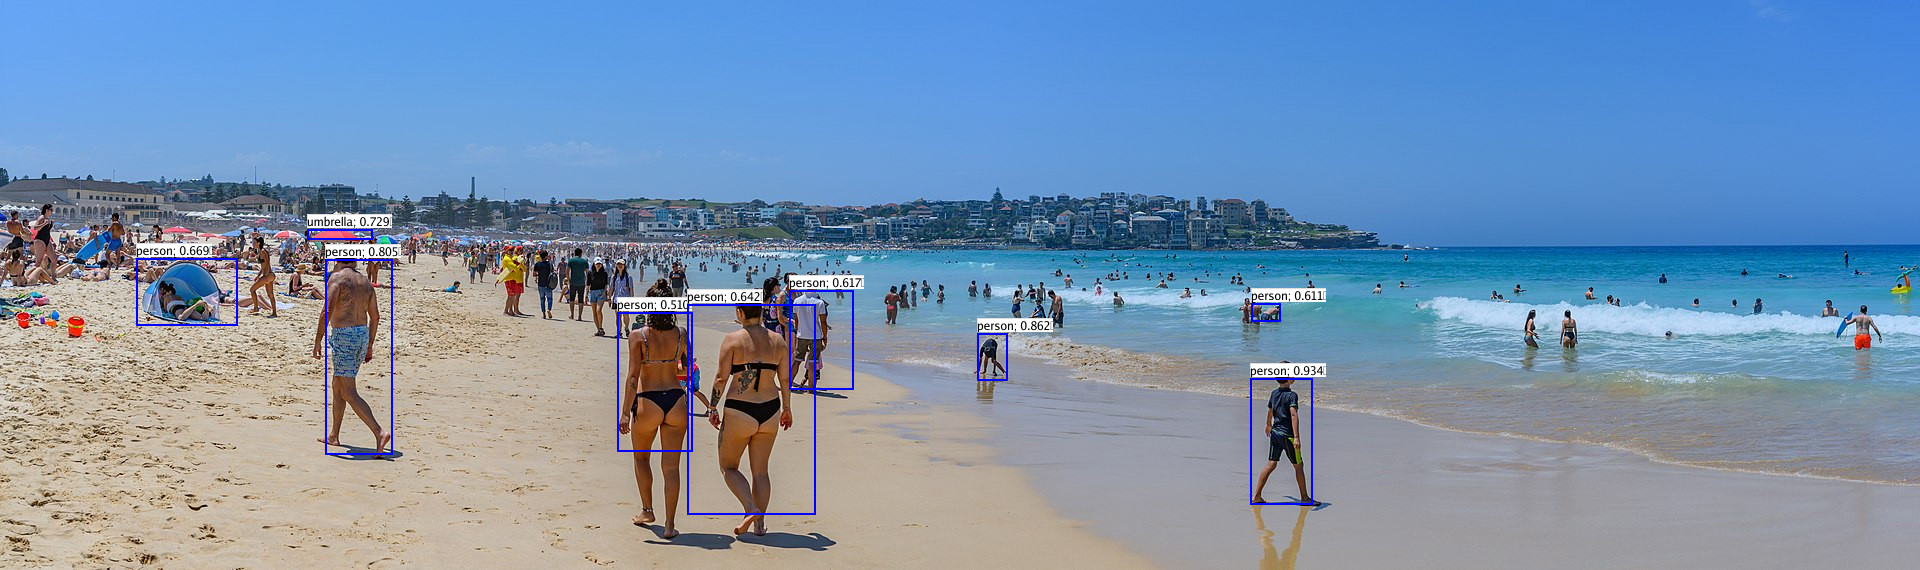

In [8]:
filename := runYolo()
display.JPEG(readImage(filename))